# ***IMPORTS***

In [ ]:
import os
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report


# ***MOUNT DRIVE***

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


# ***PATHS (EDIT)***

In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset_clean/Train"
TEST_DIR  = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset_clean/Test"

MODEL_PATH = "/content/drive/MyDrive/Models/convnext_tiny_tumor.keras"


In [ ]:
os.path.exists(TRAIN_DIR)
os.path.exists(TEST_DIR)

True

# ***CONFIG***

In [ ]:
IMG_SIZE = 384
BATCH_SIZE = 16
SEED = 42

WARMUP_EPOCHS = 3
HEAD_EPOCHS   = 5
FT1_EPOCHS    = 6
FT2_EPOCHS    = 4

TARGET_ACC = 0.90

GRAPHS=[]

# ***TRAIN + VAL***

In [ ]:
train_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_raw.class_names
NUM_CLASSES = len(class_names)

print("Classes:", class_names)


Found 9650 files belonging to 4 classes.
Using 7720 files for training.
Found 9650 files belonging to 4 classes.
Using 1930 files for validation.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# ***TEST***

In [ ]:
test_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)


Found 2180 files belonging to 4 classes.


# ***AUGMENT***

In [ ]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.15)
])


# ***PREPROCESS***

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE


def preprocess(x, y):
    x = preprocess_input(x)
    return x, y


def augment_and_preprocess(x, y):
    x = augment(x, training=True)
    x = preprocess_input(x)
    return x, y


# ***FINAL PIPELINES***

In [ ]:
train_ds = train_raw.map(
    augment_and_preprocess,
    num_parallel_calls=AUTOTUNE
)

val_ds = val_raw.map(
    preprocess,
    num_parallel_calls=AUTOTUNE
)

test_ds = test_raw.map(
    preprocess,
    num_parallel_calls=AUTOTUNE
)


train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


# ***CLASS WEIGHTS***

In [ ]:
labels = []

for _, y in train_raw:
    labels.extend(np.argmax(y.numpy(), axis=1))

labels = np.array(labels)

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(weights))

print("Class weights:", class_weights)


Class weights: {0: np.float64(0.8004977187888843), 1: np.float64(1.107921928817451), 2: np.float64(1.238767650834403), 3: np.float64(0.9606769537083126)}


# ***CALLBACKS***

In [ ]:
callbacks = [

    tf.keras.callbacks.ModelCheckpoint(
        "best_stage.h5",
        monitor="val_loss",
        save_best_only=True
    ),

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=2,
        factor=0.3,
        min_lr=1e-6
    )
]


BUILD

In [ ]:
base_model = ConvNeXtTiny(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False


inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))

x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(256, activation="gelu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(
    NUM_CLASSES,
    activation="softmax"
)(x)


model = tf.keras.Model(inputs, outputs)

model.summary()


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 12, 12, 768)    │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,021,092 (106.89 MB)

 Trainable params: 199,428 (779.02 KB)

 Non-trainable params: 27,821,664 (106.13 MB)

# ***LOSS***

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

metrics = [
    "accuracy",
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]


# ***TRAINING***

# ***`WARMUP`***

In [ ]:
print("Warmup...")

model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-3),
    loss=loss_fn,
    metrics=metrics
)

hist_warmup = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=WARMUP_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

model.load_weights("best_stage.h5")
GRAPHS.append(hist_warmup)

Warmup...
Epoch 1/3
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7369 - loss: 0.9216 - precision: 0.7742 - recall: 0.6930

483/483 ━━━━━━━━━━━━━━━━━━━━ 178s 307ms/step - accuracy: 0.7370 - loss: 0.9214 - precision: 0.7743 - recall: 0.6931 - val_accuracy: 0.8720 - val_loss: 0.6191 - val_precision: 0.9103 - val_recall: 0.8254 - learning_rate: 0.0010
Epoch 2/3
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8701 - loss: 0.6336 - precision: 0.8980 - recall: 0.8265

483/483 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.8701 - loss: 0.6335 - precision: 0.8981 - recall: 0.8266 - val_accuracy: 0.9010 - val_loss: 0.5833 - val_precision: 0.9218 - val_recall: 0.8674 - learning_rate: 0.0010
Epoch 3/3
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8971 - loss: 0.5874 - precision: 0.9238 - recall: 0.8614

483/483 ━━━━━━━━━━━━━━━━━━━━ 50s 102ms/step - accuracy: 0.8971 - loss: 0.5873 - precision: 0.9238 - recall: 0.8614 - val_accuracy: 0.9124 - val_loss: 0.5453 - val_precision: 0.9409 - val_recall: 0.8902 - learning_rate: 0.0010


# ***HEAD***

In [ ]:
print("Head Training...")

hist_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=HEAD_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

model.load_weights("best_stage.h5")
GRAPHS.append(hist_head)

Head Training...
Epoch 1/5
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9149 - loss: 0.5522 - precision: 0.9394 - recall: 0.8845

483/483 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.9149 - loss: 0.5522 - precision: 0.9394 - recall: 0.8845 - val_accuracy: 0.9254 - val_loss: 0.5394 - val_precision: 0.9398 - val_recall: 0.8974 - learning_rate: 0.0010
Epoch 2/5
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9191 - loss: 0.5425 - precision: 0.9423 - recall: 0.8845

483/483 ━━━━━━━━━━━━━━━━━━━━ 50s 102ms/step - accuracy: 0.9192 - loss: 0.5425 - precision: 0.9423 - recall: 0.8846 - val_accuracy: 0.9202 - val_loss: 0.5324 - val_precision: 0.9426 - val_recall: 0.9021 - learning_rate: 0.0010
Epoch 3/5
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9317 - loss: 0.5332 - precision: 0.9490 - recall: 0.9023

483/483 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.9317 - loss: 0.5332 - precision: 0.9490 - recall: 0.9024 - val_accuracy: 0.9244 - val_loss: 0.5270 - val_precision: 0.9447 - val_recall: 0.9036 - learning_rate: 0.0010
Epoch 4/5
482/483 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9282 - loss: 0.5197 - precision: 0.9502 - recall: 0.9026

483/483 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.9282 - loss: 0.5197 - precision: 0.9502 - recall: 0.9026 - val_accuracy: 0.9352 - val_loss: 0.5161 - val_precision: 0.9504 - val_recall: 0.9135 - learning_rate: 0.0010
Epoch 5/5
483/483 ━━━━━━━━━━━━━━━━━━━━ 49s 100ms/step - accuracy: 0.9400 - loss: 0.5086 - precision: 0.9578 - recall: 0.9103 - val_accuracy: 0.9269 - val_loss: 0.5248 - val_precision: 0.9442 - val_recall: 0.9036 - learning_rate: 0.0010


# ***FT1 (50%)***

In [ ]:
print("Fine-tune 50%...")


n = len(base_model.layers)
unfreeze = int(0.5 * n)

for layer in base_model.layers[unfreeze:]:
    layer.trainable = True


model.compile(
    optimizer=tf.keras.optimizers.AdamW(5e-5),
    loss=loss_fn,
    metrics=metrics
)


hist_ft1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT1_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

model.load_weights("best_stage.h5")
GRAPHS.append(hist_ft1)

Fine-tune 50%...
Epoch 1/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9500 - loss: 0.4974 - precision: 0.9580 - recall: 0.9168

483/483 ━━━━━━━━━━━━━━━━━━━━ 220s 372ms/step - accuracy: 0.9500 - loss: 0.4974 - precision: 0.9581 - recall: 0.9168 - val_accuracy: 0.9456 - val_loss: 0.4995 - val_precision: 0.9571 - val_recall: 0.9244 - learning_rate: 5.0000e-05
Epoch 2/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9779 - loss: 0.4420 - precision: 0.9858 - recall: 0.9678

483/483 ━━━━━━━━━━━━━━━━━━━━ 151s 309ms/step - accuracy: 0.9779 - loss: 0.4420 - precision: 0.9858 - recall: 0.9678 - val_accuracy: 0.9627 - val_loss: 0.4537 - val_precision: 0.9705 - val_recall: 0.9560 - learning_rate: 5.0000e-05
Epoch 3/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9863 - loss: 0.4278 - precision: 0.9896 - recall: 0.9766

483/483 ━━━━━━━━━━━━━━━━━━━━ 151s 309ms/step - accuracy: 0.9863 - loss: 0.4277 - precision: 0.9896 - recall: 0.9766 - val_accuracy: 0.9772 - val_loss: 0.4267 - val_precision: 0.9858 - val_recall: 0.9705 - learning_rate: 5.0000e-05
Epoch 4/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9939 - loss: 0.4120 - precision: 0.9958 - recall: 0.9851

483/483 ━━━━━━━━━━━━━━━━━━━━ 151s 309ms/step - accuracy: 0.9939 - loss: 0.4120 - precision: 0.9958 - recall: 0.9851 - val_accuracy: 0.9767 - val_loss: 0.4251 - val_precision: 0.9863 - val_recall: 0.9689 - learning_rate: 5.0000e-05
Epoch 5/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9953 - loss: 0.4028 - precision: 0.9975 - recall: 0.9920

483/483 ━━━━━━━━━━━━━━━━━━━━ 150s 309ms/step - accuracy: 0.9953 - loss: 0.4028 - precision: 0.9975 - recall: 0.9920 - val_accuracy: 0.9782 - val_loss: 0.4179 - val_precision: 0.9843 - val_recall: 0.9725 - learning_rate: 5.0000e-05
Epoch 6/6
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9973 - loss: 0.3971 - precision: 0.9982 - recall: 0.9925

483/483 ━━━━━━━━━━━━━━━━━━━━ 150s 309ms/step - accuracy: 0.9973 - loss: 0.3971 - precision: 0.9982 - recall: 0.9925 - val_accuracy: 0.9845 - val_loss: 0.4045 - val_precision: 0.9890 - val_recall: 0.9782 - learning_rate: 5.0000e-05


# ***FT2 (IF < 90%)***

In [ ]:
best_val = max(hist_ft1.history["val_accuracy"])

print("Best Val:", best_val)


if best_val < TARGET_ACC:

    print("Full Fine-tuning...")

    base_model.trainable = True


    model.compile(
        optimizer=tf.keras.optimizers.AdamW(2e-5),
        loss=loss_fn,
        metrics=metrics
    )


    hist_ft2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FT2_EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights
    )
    GRAPHS.append(hist_ft2)
    model.load_weights("best_stage.h5")


Best Val: 0.984455943107605


# ***GRAPH***

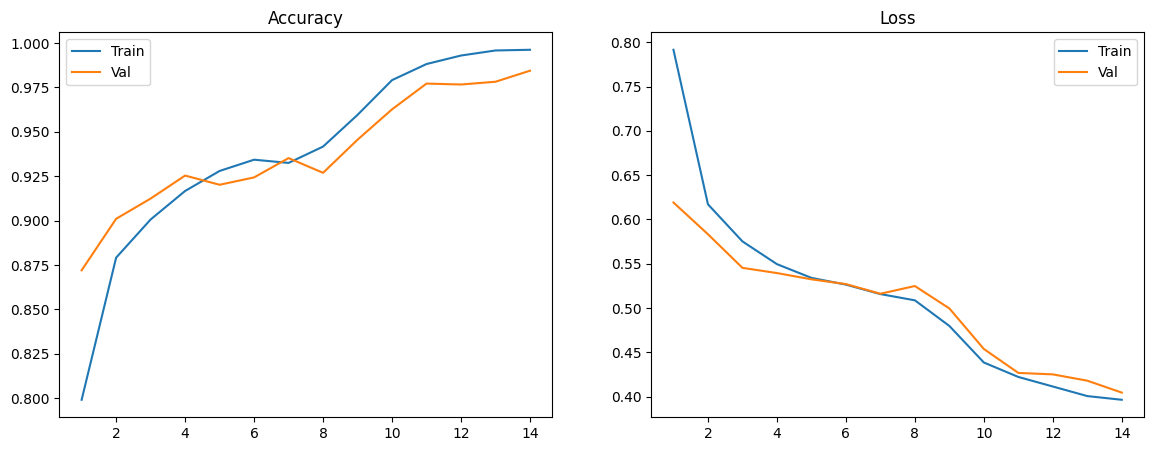

In [ ]:
def plot_history(histories):

    acc, val_acc, loss, val_loss = [], [], [], []

    for h in histories:

        acc += h.history["accuracy"]
        val_acc += h.history["val_accuracy"]

        loss += h.history["loss"]
        val_loss += h.history["val_loss"]


    e = range(1, len(acc)+1)


    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(e, acc, label="Train")
    plt.plot(e, val_acc, label="Val")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(e, loss, label="Train")
    plt.plot(e, val_loss, label="Val")
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_history(GRAPHS)

# ***TEST***

In [ ]:
model.evaluate(test_ds)


137/137 ━━━━━━━━━━━━━━━━━━━━ 137s 994ms/step - accuracy: 0.9485 - loss: 0.4670 - precision: 0.9635 - recall: 0.9357


[0.4629051983356476,
 0.9504587054252625,
 0.9645892381668091,
 0.9371559619903564]

# ***CONFUSION MATRIX***

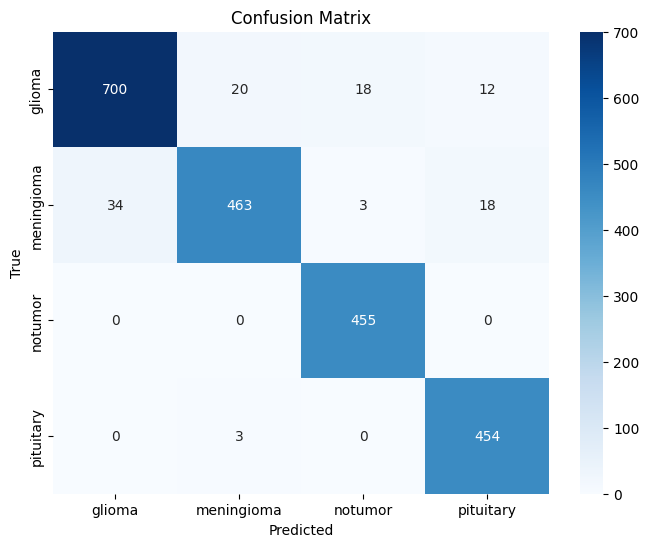

              precision    recall  f1-score   support

      glioma       0.95      0.93      0.94       750
  meningioma       0.95      0.89      0.92       518
     notumor       0.96      1.00      0.98       455
   pituitary       0.94      0.99      0.96       457

    accuracy                           0.95      2180
   macro avg       0.95      0.96      0.95      2180
weighted avg       0.95      0.95      0.95      2180



In [ ]:
y_true = []
y_pred = []


for x, y in test_ds:

    p = model.predict(x, verbose=0)

    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(p, axis=1))


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8,6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()


print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


# ***SAVE***

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Project work/models/convnext_tiny_tumor.keras"

In [ ]:
model.save(MODEL_PATH)

model.save(MODEL_PATH.replace(".keras", ".h5"))

print("Saved:", MODEL_PATH)


Saved: /content/drive/MyDrive/Project work/models/convnext_tiny_tumor.keras
